Adapt the code from the Vipir to read a frame from the Grid-eye and post via mqtt the flattened array, for leading in the subscribe notebook

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import smbus
I2C_ADDRESS = 0x68
I2C_BUS = smbus.SMBus(1)
REALTIME = True

In [3]:
import os
import sys

import numpy as np
from bitstring import Bits
import json


class FrameReader:
    def __init__(self):
        self.thermistor = None

    def get_image(self, img_from_usb=None):

        if REALTIME:
            try:
                thermistor_bin = [
                    bin(I2C_BUS.read_byte_data(I2C_ADDRESS, 0x0e)),
                    bin(I2C_BUS.read_byte_data(I2C_ADDRESS, 0x0f))
                ]
            except (AttributeError, OSError) as error:
                logger.error("Failed to read data from I2C_BUS: %s", error)
                sys.exit(1)

            image_bin = self.get_image_bin()
        self.thermistor = self.get_thermistor(thermistor_bin)
        image = np.zeros((64,))
        for pixel_i in range(len(image_bin)):  # pylint: disable=C0200
            image[pixel_i] = self.get_pixel(image_bin[pixel_i])
        image = image.reshape((8, 8))
        return self.thermistor, image

    def parse_from_usb(self, packet):
        packet = self.remove_prefix_subfix(packet)
        return packet[:2], packet[2:]

    @staticmethod
    def remove_prefix_subfix(packet):
        """
        removes prefix and suffix of the packet
        :param packet: packet with *** prefix and \CR\LF suffix
        :return: data of packet
        """
        packet = list(map(lambda x: bin(x), packet))
        packet = packet[3:-2]  # remove '***' prefix and \CR\LF suffix
        return packet

    @staticmethod
    def get_thermistor(thermistor_bin):
        tthl = thermistor_bin[0]
        tthh = thermistor_bin[1]
        thermostat_bin = str(tthh).split('b')[-1].zfill(4) + str(tthl).split('b')[-1].zfill(8)
        thermostat_temp_abs = int(thermostat_bin[1:], 2) * 0.0625
        thermostat_sign = int(thermostat_bin[1])
        if not thermostat_sign:
            return thermostat_temp_abs
        else:
            return -1 * thermostat_temp_abs

    @staticmethod
    def get_image_bin():
        image = []
        for i in range(0, 128, 2):
            low = I2C_BUS.read_byte_data(I2C_ADDRESS, 128 + i)
            high = I2C_BUS.read_byte_data(I2C_ADDRESS, 128 + i + 1)
            image.append((bin(low), bin(high)))
        return image

    @staticmethod
    def get_pixel(image_bin_i):
        data_l = image_bin_i[0]
        data_h = image_bin_i[1]
        pixel_bin = str(data_h).split('b')[-1].zfill(4) + str(data_l).split('b')[-1].zfill(8)
        pixel_temp = Bits(bin=pixel_bin).int * 0.25
        return pixel_temp

In [4]:
grideye = FrameReader()

In [8]:
thermistor, frame = grideye.get_image()

In [9]:
frame

array([[33.5 , 32.75, 31.75, 32.  , 31.25, 30.75, 31.25, 30.75],
       [33.5 , 32.25, 32.5 , 32.25, 31.75, 30.75, 31.  , 31.75],
       [33.25, 33.5 , 32.5 , 32.  , 32.5 , 31.5 , 31.  , 31.5 ],
       [31.75, 32.75, 32.75, 33.25, 32.  , 31.  , 31.  , 31.5 ],
       [29.5 , 30.25, 32.25, 33.75, 29.5 , 30.5 , 31.75, 31.25],
       [28.5 , 29.25, 31.75, 33.5 , 30.  , 30.5 , 30.25, 30.75],
       [28.25, 28.75, 29.  , 31.25, 29.5 , 30.5 , 30.25, 30.75],
       [28.5 , 28.  , 27.75, 27.25, 29.  , 30.  , 29.75, 30.75]])

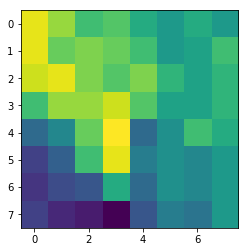

In [10]:
plt.imshow(frame);

In [11]:
img_file = 'frame.jpg'
plt.imsave(img_file, frame);

In [12]:
frame_json = json.dumps(frame.flatten().tolist()) # flatten for dumping to json 
frame_json

'[33.5, 32.75, 31.75, 32.0, 31.25, 30.75, 31.25, 30.75, 33.5, 32.25, 32.5, 32.25, 31.75, 30.75, 31.0, 31.75, 33.25, 33.5, 32.5, 32.0, 32.5, 31.5, 31.0, 31.5, 31.75, 32.75, 32.75, 33.25, 32.0, 31.0, 31.0, 31.5, 29.5, 30.25, 32.25, 33.75, 29.5, 30.5, 31.75, 31.25, 28.5, 29.25, 31.75, 33.5, 30.0, 30.5, 30.25, 30.75, 28.25, 28.75, 29.0, 31.25, 29.5, 30.5, 30.25, 30.75, 28.5, 28.0, 27.75, 27.25, 29.0, 30.0, 29.75, 30.75]'

## MQTT
We can publish to mqtt - either save an image (compressed, colorised) or post the json

In [13]:
import paho.mqtt.client as mqtt
import paho.mqtt.publish as publish 
import time
import os

### MQTT 
broker = "localhost"
port = 1883
camera_topic = 'camera/'

In [14]:
def on_connect(client, userdata, flags, rc):
    print("CONNACK received with code {}".format(rc))
    if rc==0:
        print("connected OK")
    else:
        print("Bad connection Returned code=",rc)

In [15]:
client = mqtt.Client()
client.on_connect = on_connect
#client.username_pw_set(username, password)
client.connect(broker, port=port)
client.loop_start()

CONNACK received with code 0
connected OK


Post the RGB image

In [16]:
with open(img_file, 'rb') as file:
    bytes_read = file.read()  
    byte_array = bytearray(bytes_read)
    client.publish(camera_topic, byte_array)

Post the json

In [17]:
client.publish('camera/json', frame_json)

In [ ]:
`